In [1]:
import os
os.environ["PATH"] = "/usr/local/cuda-11.8/bin:{}".format(os.environ["PATH"])
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-11.8/lib64"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import sys
sys.path.append("/home/yang_liu/python_workspace/gaussian-splatting-lightning")

import torch
import numpy as np
import random

from internal.utils.ssim import ssim
from matplotlib import pyplot as plt
from gsplat.rasterize import rasterize_gaussians
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.dataparsers.colmap_dataparser import ColmapParams, ColmapDataParser
from internal.dataparsers.colmap_block_dataparser import ColmapBlockParams, ColmapBlockDataParser
from internal.renderers.vanilla_renderer import VanillaRenderer
from internal.utils.sh_utils import eval_gaussian_model_sh

torch.set_grad_enabled(False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# load model and dataset
model, renderer = GaussianModelLoader.search_and_load(
    "../outputs/citygs2d_rubble/blocks/block_5",
    sh_degree=3,
    device="cuda",
)
print("Gaussian count: {}".format(model.get_xyz.shape[0]))
# dataset
dataparser_outputs = ColmapBlockDataParser(
    os.path.expanduser("../data/mill19/rubble-pixsfm/train"),
    os.path.abspath(""),
    global_rank=0,
    params=ColmapBlockParams(
        image_list="../data/mill19/rubble-pixsfm/train/partition/3_1_3_2D",
        num_threshold=25000,
        content_threshold=0.12,
        down_sample_factor=4,
        block_id=5,
        block_dim=[3,1,3],
        aabb=[-50, -100, -135, 50, 300, -5],
    ),
).get_outputs()
print("Train camera count: {}".format(len(dataparser_outputs.train_set.cameras)))

Gaussian count: 10090718
appearance group by camera id
loading colmap 3D points
down sample enabled
[colmap dataparser] train set images: 395, val set images: 50, loaded mask: 0
Train camera count: 395


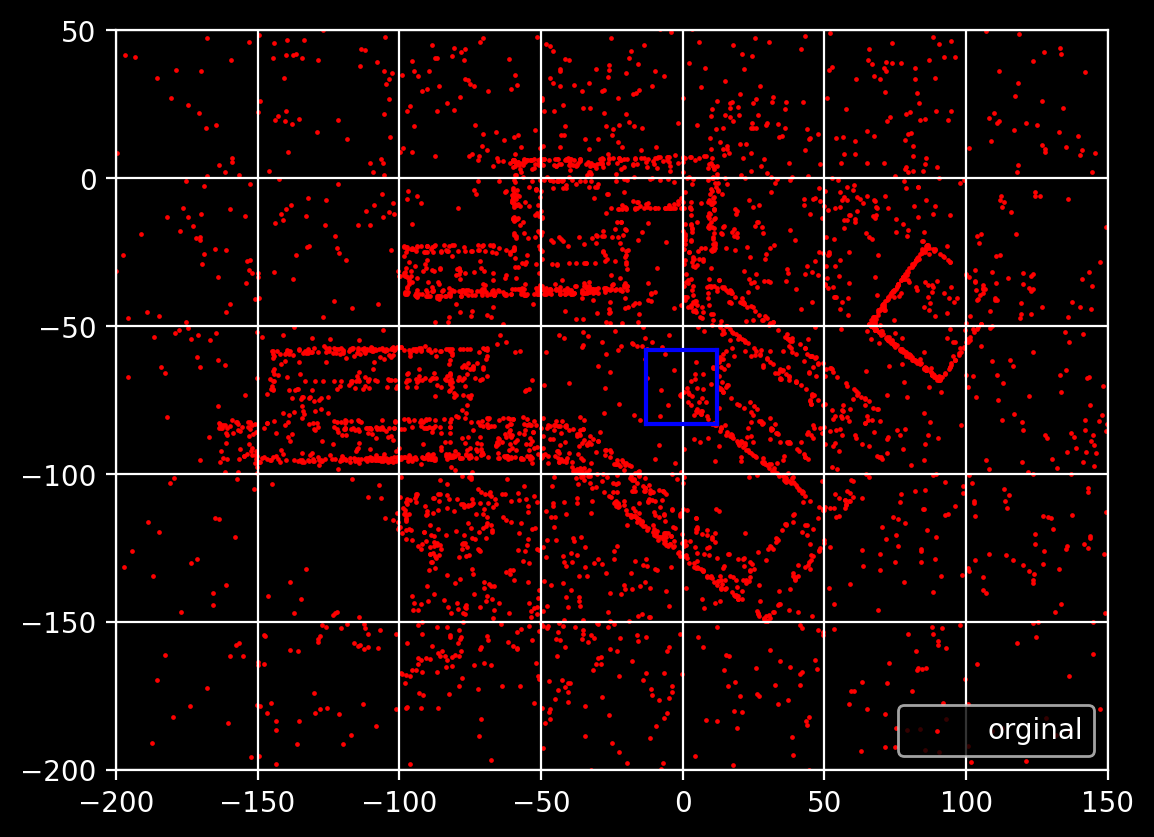

In [10]:
plt.figure()
xyz_org = model.get_xyz
plt.scatter(xyz_org[::200, 0].detach().cpu(), xyz_org[::200, 2].detach().cpu(), s=0.5, c='r', label='orginal')
plt.xlim(-200, 150)
plt.ylim(-200, 50)
bbox_min = np.array([-13.0479,  26.7363, -83.0341])
bbox_max = np.array([11.9779,  51.7621, -58.0082])
# draw the line
plt.plot([bbox_min[0], bbox_min[0]], [bbox_min[2], bbox_max[2]], 'b')
plt.plot([bbox_max[0], bbox_max[0]], [bbox_min[2], bbox_max[2]], 'b')
plt.plot([bbox_min[0], bbox_max[0]], [bbox_min[2], bbox_min[2]], 'b')
plt.plot([bbox_min[0], bbox_max[0]], [bbox_max[2], bbox_max[2]], 'b')
# plt.xticks(np.linspace(0,1,block_dim[0]+1,endpoint=True))
# plt.yticks(np.linspace(0,1,block_dim[2]+1,endpoint=True))
plt.legend()
plt.grid(True)
plt.show()

In [3]:
ckpt = torch.load("../outputs/citygs2d_rubble/blocks/block_5/checkpoints/epoch=28-step=10999.ckpt")["gaussian_model_extra_state_dict"]
max_radii2D, xyz_gradient_accum, denom = ckpt["max_radii2D"], ckpt["xyz_gradient_accum"], ckpt["denom"]

In [4]:
org_xyz = model._xyz.clone()

In [5]:
# grad = (xyz_gradient_accum / denom).squeeze()
grad = xyz_gradient_accum.squeeze()
grad_mean = xyz_gradient_accum.mean()
grad_std = xyz_gradient_accum.std()
grad_mask = grad < grad_mean + grad_std
# grad_mask = torch.zeros_like(grad, dtype=torch.bool)
# grad_mask = (model.get_scaling[:, :2].min(dim=1)[0] / model.get_scaling[:, :2].max(dim=1)[0]) > 0.01
model.select(grad_mask)
model._scaling = model._scaling[:, [1,0,2]]
# model._xyz[~grad_mask] = org_xyz[~grad_mask].clone()
# model._xyz[~grad_mask] = model._xyz[~grad_mask] * 1.02
# model._scaling = model._scaling[:, [1,0,2]]

In [6]:
# pick a camera
# idx = random.randint(0, len(dataparser_outputs.train_set.cameras) - 1)
idx = 55  # 55, 263, 8
camera = dataparser_outputs.train_set.cameras[idx].to_device("cuda")
image_path = dataparser_outputs.train_set.image_paths[idx]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1151.5, 863.5, -0.5)

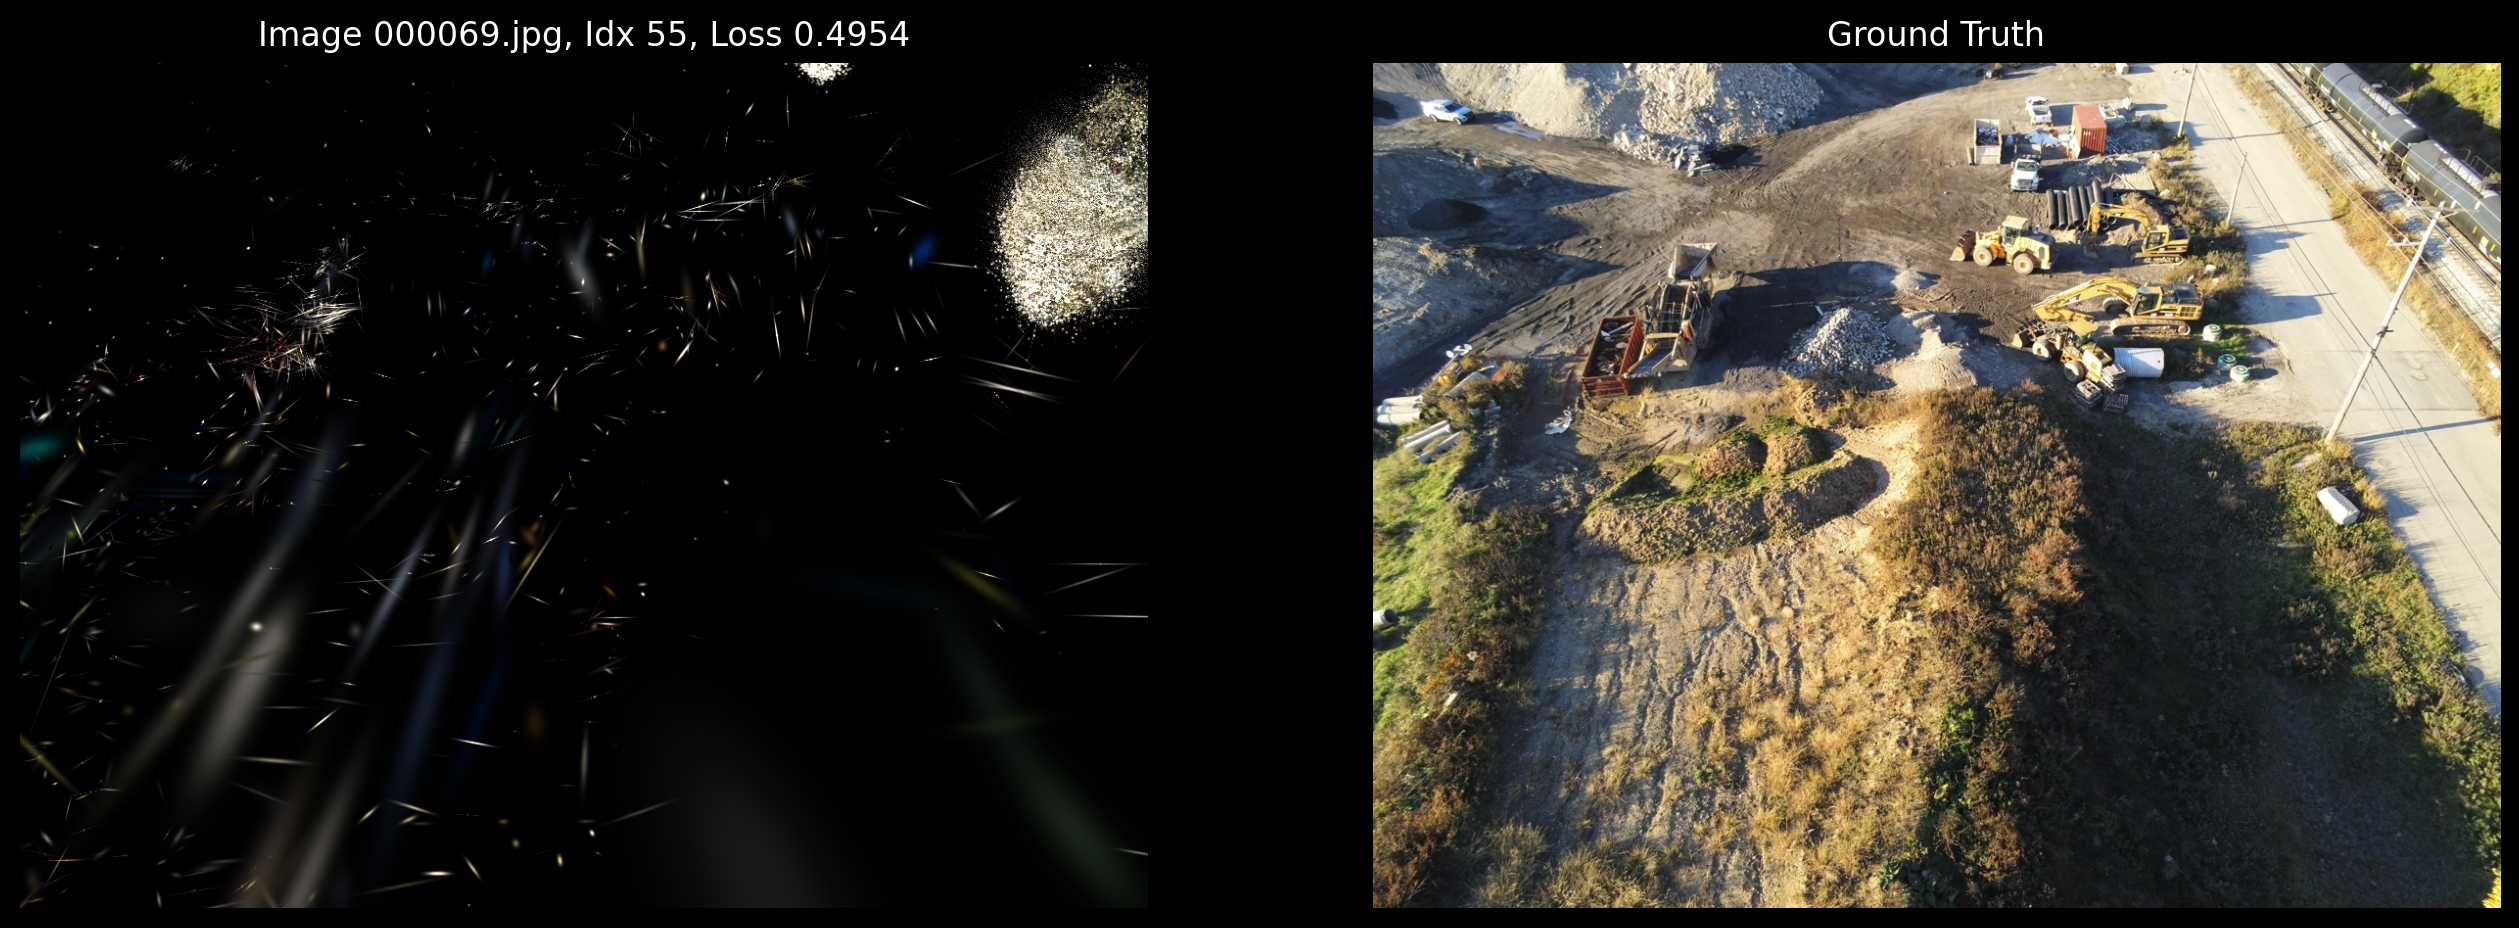

In [7]:
# Test image render
with torch.no_grad():
    gt = torch.tensor(plt.imread(image_path), dtype=torch.float, device="cuda").permute(2, 0, 1) / 255.0
    results = renderer(camera, model, bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"))
    loss = 0.2 * (1 - ssim(results["render"], gt).item()) + 0.8 * torch.abs(results["render"] - gt).mean().item()

plt.figure(figsize=(16, 8))
plt.tight_layout()
plt.subplot(1, 2, 1)
plt.imshow(results["render"].permute(1, 2, 0).cpu().numpy())
plt.title(f"Image {dataparser_outputs.train_set.image_names[idx]}, Idx {idx}, Loss {loss:.4f}")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(gt.permute(1, 2, 0).cpu().numpy())
plt.title("Ground Truth")
plt.axis('off')


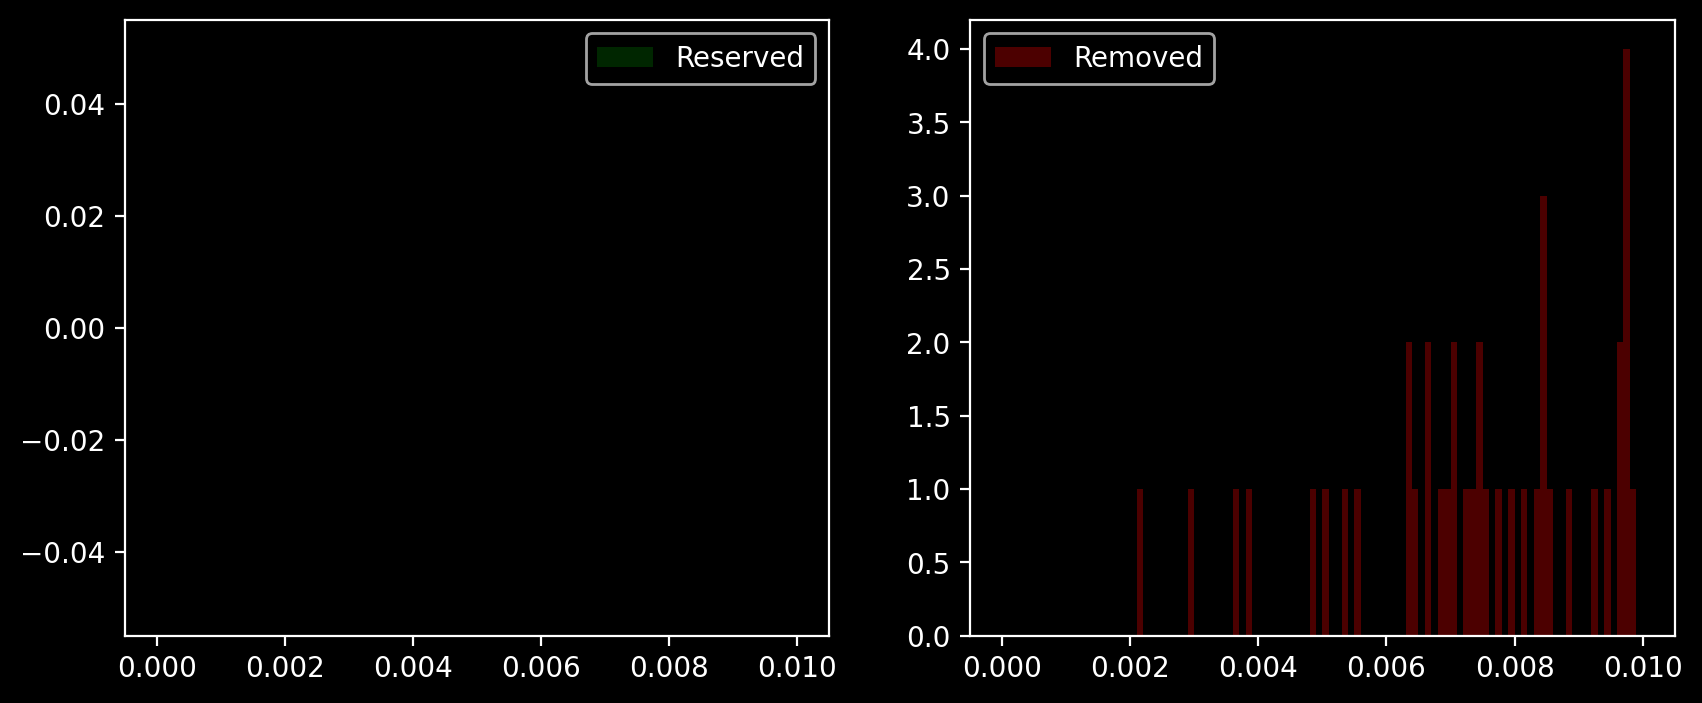

In [8]:
radius_reserved = model.get_scaling[~grad_mask.squeeze(), :2].norm(dim=1)
radius_removed = model.get_scaling[grad_mask.squeeze(), :2].norm(dim=1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(radius_reserved.cpu().numpy(), bins=100, range=(0, 0.01), alpha=0.3, color='g', label="Reserved");
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(radius_removed.cpu().numpy(), bins=100, range=(0, 0.01), alpha=0.3, color='r', label="Removed");
plt.legend()
plt.show()

# scaling_reserved = max_radii2D[~grad_mask.squeeze() & (results["radii"]>0)]
# scaling_removed = max_radii2D[grad_mask.squeeze() & (results["radii"]>0)]
# print(f"Average scaling of reserved gaussians: {scaling_reserved.mean(dim=0)}")
# print(f"Average scaling of removed gaussians: {scaling_removed.mean(dim=0)}")